In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import math

import os
from typing import Tuple
from tqdm import tqdm
from glob import glob
from PIL import Image

Workflow:

    1) Generate the mask
    2) Generate the run length encoding
    3) Perform tiling and save tiles

In [3]:
# Adapted from: https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script

def rle_to_mask(rle: str, img_width: int, img_height: int) -> np.array:
    """Generate the mask for a given image.

    Args:
        rle: the run length encoded image
        img_width: width of an image
        img_height: height of the image

    Returns:
        np.array: the image array with labels    
    """
    
    rle = rle.split()
    
    # split the list into start indices and length 
    starts, lengths = list((np.array(rle, dtype=int)[::2], np.array(rle, dtype=int)[1::2]))
    
    # create start and end indices 
    starts -= 1
    ends = starts + lengths
    
    # create a vector of zeros 
    img = np.zeros(img_height*img_width, dtype=np.uint8)
    
    # populate the vector
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    # return the mask
    return img.reshape((img_height, img_width)).T

In [4]:
# Adapted from: https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script

def mask_to_rle(img: np.array) -> str:
    """Get the run length encoding for a given segmented image/mask.

    Args:
        img_array: the run length encoded string

    Returns:
        str: the run length encoded representation of a segmented image
    """
    
    # transpose and flatten the image
    pixels = img.T.flatten()
    
    # add zeros at the start and beginning of the vector
    pixels = np.concatenate([[0], pixels, [0]])
    
    # capture the changes, i.e. where does a 1 start and where does it end
    # add a 1 since the rle starts from 1 and not 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    
    # subtract every second value from its previous value (to get the length)
    runs[1::2] -= runs[::2]
    
    # return a string representation, without square brackets
    return str(runs)[1:-1]

In [5]:
def generate_tiles(img_path: str, mask: np.array, padding_mode: str, tile_size: int):
    """Generate tiles for a given image and mask.
    
    Args:
        img_path: path of the image file
        mask: the mask to tile
        padding_mode: how to pad, e.g. "constant"
        tile_size: the size of the tiles
    """    
    
    img = np.asarray(Image.open(img_path))
    img_id = img_path.split("/")[-1].replace(".tiff", "")
    
    base_img_save_path = "/kaggle/working/images/" + img_id
    base_mask_save_path = "/kaggle/working/masks/" + img_id
            
    if img.shape[1] % 2 != 0: # pad if the height/width has an uneven number of pixel
        img = np.pad(img, ((1,0), (1,0), (0,0)), padding_mode) # pad first row and first column with a single row/column of zeros
        mask = np.pad(mask, (1,0), padding_mode) # pad first row and first column with a single row/column of zeros
        
    excess_pixels = img.shape[0] % tile_size
    pixels_to_pad_per_side = int((tile_size - excess_pixels) / 2)
    img = np.pad(img, ((pixels_to_pad_per_side,pixels_to_pad_per_side),(pixels_to_pad_per_side,pixels_to_pad_per_side),(0,0)), padding_mode) # pad first row and first column
    mask = np.pad(mask, (pixels_to_pad_per_side,pixels_to_pad_per_side), padding_mode) # pad first row and first column
    
    k = 0
    for i in range(0, len(img), tile_size):
        for j in range(0, len(img), tile_size):

            img_temp = Image.fromarray(img[i:i+tile_size, j:j+tile_size, :])
            img_temp.save(base_img_save_path + f"_{k}.png")
            
            mask_temp = Image.fromarray(mask[i:i+tile_size, j:j+tile_size]).convert("L")
            mask_temp.save(base_mask_save_path + f"_{k}.png")
            k += 1

### Test on a single training example

In [6]:
base_path_label = "/kaggle/input/hubmap-organ-segmentation/train_annotations/"
base_path_image = "/kaggle/input/hubmap-organ-segmentation/train_images/"
train_metadata = "/kaggle/input/hubmap-organ-segmentation/train.csv"
example_file_name = "11448" 

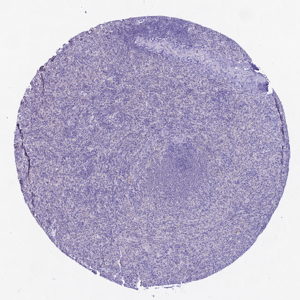

In [7]:
# example image
example_image_path = base_path_image + example_file_name + ".tiff"
img = Image.open(example_image_path)
img_array = np.asarray(img)
img.resize((300,300))

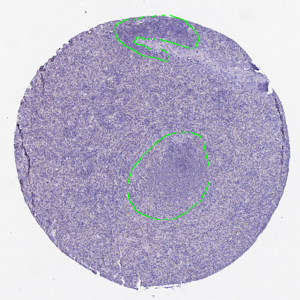

In [8]:
# read the an example annotations file
with open(base_path_label + example_file_name + ".json", "r") as f:
    json_file = json.load(f)

# visualize the label boundaries
for mask in json_file:
    for part in mask:
        img_array[part[1]-5:part[1]+5, part[0]-5:part[0]+5] = [0, 255, 0]
        
Image.fromarray(img_array).resize((300,300))

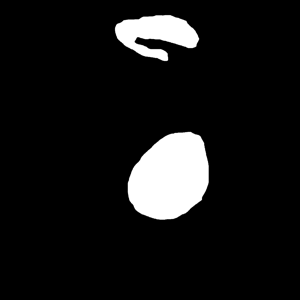

In [9]:
# generate the mask for a given image
train_csv = pd.read_csv(train_metadata)

rle = train_csv[train_csv.id == int(example_file_name)].rle.iloc[0]
img_height = train_csv[train_csv.id == int(example_file_name)].img_height.iloc[0]
img_width = train_csv[train_csv.id == int(example_file_name)].img_width.iloc[0]

img_array = rle_to_mask(rle, img_width, img_height)
Image.fromarray(np.uint8(img_array*255)).resize((300,300))

In [10]:
# generate the rle for a given segmented image/mask
run_length_encoding = mask_to_rle(img_array)

### Generate tiles of images and masks

In [15]:
# create new directories to save the tiles and masks
os.makedirs("/kaggle/working/images/")
os.makedirs("/kaggle/working/masks/")

# possible hyperparameters to tune
padding_mode = "constant"
tile_size = 256 

for i, row in tqdm(enumerate(train_csv.itertuples())):
    mask = rle_to_mask(row.rle, row.img_width, row.img_height)                     
    generate_tiles(row.train_image_path, mask, padding_mode, tile_size)

351it [30:53,  5.28s/it]
